# <center> **Optimización Bayesiana para la Selección de Hiperparámetros en Modelos de Detección de Tumores Cerebrales** </center>

In [81]:
import torch
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import bayes_opt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from torchsummary import summary

# **Carga de los datos**

In [2]:

# Transformación y carga de las imagenes.
data_transforms = torchvision.transforms.Compose([
torchvision.transforms.Resize((224,224)),
torchvision.transforms.RandomHorizontalFlip(),
torchvision.transforms.RandomRotation(20),
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder('imagenes/Training',
                                              transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=20,shuffle=True)


test_data = torchvision.datasets.ImageFolder('imagenes/Testing',
                                              transform=data_transforms)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=20,shuffle=False)


In [74]:

def plot_label_distribution_percentage(dataloader, class_names):
   
    # Contar las etiquetas
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())  # Convertir a numpy y agregar a la lista

    label_counts = Counter(all_labels)  # Contar las etiquetas
    total_count = sum(label_counts.values())  # Total de etiquetas
    sorted_labels = sorted(label_counts.items())  # Ordenar por clase

    # Extraer clases y porcentajes
    classes = [class_names[label] for label, _ in sorted_labels]
    percentages = [(count / total_count) * 100 for _, count in sorted_labels]

    # Graficar la distribución en porcentajes
    plt.figure(figsize=(10, 6))
    plt.bar(classes, percentages, color='skyblue', edgecolor='black')
    plt.xlabel("Clases")
    plt.ylabel("Porcentaje (%)")
    plt.title("Distribución Porcentual de Etiquetas")
    plt.xticks(rotation=45, ha="right")  # Rotar los nombres de las clases si son largos
    plt.tight_layout()
    plt.show()


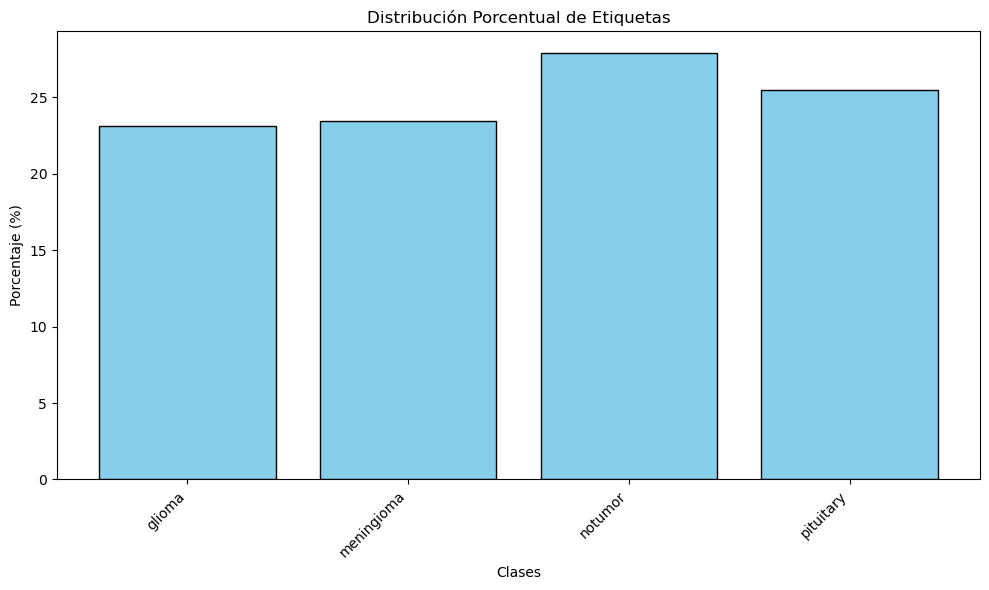

In [76]:
plot_label_distribution_percentage(train_loader, train_loader.dataset.classes)

# **Creación de la red neuronal convolucional**

In [3]:

# Creación de la arquitectura de la red neuronal Convolucional
class ConvNN(torch.nn.Module):

    def __init__(self,activation,nn = 128,dropout_rate = 0.5):
        super().__init__()
        self.activation = activation
        self.normalize1_layer = torch.nn.BatchNorm2d(3)
        # self.normalize2_layer = torch.nn.BatchNorm2d(16)
        self.normalize3_layer = torch.nn.BatchNorm2d(32)
        #self.normalize4_layer = torch.nn.BatchNorm2d(8)

        self.Droput1_layer = torch.nn.Dropout(dropout_rate)
        #self.Droput2_layer = torch.nn.Dropout(0.4)

        
        self.conv1_layer = torch.nn.Conv2d(3,16,kernel_size=3,padding=2)
        self.maxpo1_layer = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2_layer = torch.nn.Conv2d(16,32,kernel_size=3,padding=2)
        self.maxpo2_layer = torch.nn.MaxPool2d(kernel_size=2,stride=2)


        self.flatten_layer = torch.nn.Flatten()

        self.fc1_layer = torch.nn.Linear(103968,nn)
        self.fc2_layer = torch.nn.Linear(nn,4)

    def forward(self,x):

        x = self.normalize1_layer(x)
        x = self.conv1_layer(x)
        x = self.maxpo1_layer(x)
        x = self.activation(x)
        
        
        x = self.conv2_layer(x)
        x = self.maxpo2_layer(x)
        x = self.activation(x)


        x = self.normalize3_layer(x)
        x = self.flatten_layer(x)

        
        x = self.fc1_layer(x)
        x = self.activation(x)
        x = self.Droput1_layer(x)

        x = self.fc2_layer(x)
        x = torch.functional.F.softmax(x)
        
        

        return x

        
        
        
        

In [79]:
modelo_prueba = ConvNN(torch.nn.ReLU())
summary(modelo_prueba, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm2d: 1-1                       [-1, 3, 224, 224]         6
├─Conv2d: 1-2                            [-1, 16, 226, 226]        448
├─MaxPool2d: 1-3                         [-1, 16, 113, 113]        --
├─ReLU: 1-4                              [-1, 16, 113, 113]        --
├─Conv2d: 1-5                            [-1, 32, 115, 115]        4,640
├─MaxPool2d: 1-6                         [-1, 32, 57, 57]          --
├─ReLU: 1-7                              [-1, 32, 57, 57]          --
├─BatchNorm2d: 1-8                       [-1, 32, 57, 57]          64
├─Flatten: 1-9                           [-1, 103968]              --
├─Linear: 1-10                           [-1, 128]                 13,308,032
├─ReLU: 1-11                             [-1, 128]                 --
├─Dropout: 1-12                          [-1, 128]                 --
├─Linear: 1-13                           [-1, 4]                   516
Tot

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm2d: 1-1                       [-1, 3, 224, 224]         6
├─Conv2d: 1-2                            [-1, 16, 226, 226]        448
├─MaxPool2d: 1-3                         [-1, 16, 113, 113]        --
├─ReLU: 1-4                              [-1, 16, 113, 113]        --
├─Conv2d: 1-5                            [-1, 32, 115, 115]        4,640
├─MaxPool2d: 1-6                         [-1, 32, 57, 57]          --
├─ReLU: 1-7                              [-1, 32, 57, 57]          --
├─BatchNorm2d: 1-8                       [-1, 32, 57, 57]          64
├─Flatten: 1-9                           [-1, 103968]              --
├─Linear: 1-10                           [-1, 128]                 13,308,032
├─ReLU: 1-11                             [-1, 128]                 --
├─Dropout: 1-12                          [-1, 128]                 --
├─Linear: 1-13                           [-1, 4]                   516
Tot

# **Funciones para entrenar y evaluar el modelo**

In [4]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs= model(images)
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [5]:
# Asegurarnos de tener un dispositivo adecuado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


models = []
act = torch.nn.ReLU()
# Crear una instancia del modelo
model = ConvNN(activation=act).to(device)

# Definir el optimizador y la función de pérdida
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Función para entrenar el modelo
def train_model(model, train_loader, criterion, optimizer, epochs=10,save_model = True):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Reiniciar gradientes
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass y optimización
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels).item()
        
        # Estadísticas de entrenamiento por época
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        test_accuracy = evaluate_model(model,test_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {epoch_accuracy:.4f}%, Test Accuracy: {test_accuracy:.4f}%')

    if save_model:

        models.append(model)

    return epoch_accuracy, test_accuracy


# Entrenamiento y evaluación
#epochs = 1
#train_model(model, train_loader, criterion, optimizer, epochs)
# evaluate_model(model, test_loader)


# **Optimización Bayesiana**

In [6]:

act_functions = [torch.nn.ReLU(),torch.nn.Tanh()]

# Función objetivo
def blackbox_function(activation,nn,lr,epochs,dropout_rate):

    model = ConvNN(activation=act_functions[int(activation)],dropout_rate=dropout_rate,nn=int(nn)).to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_accuracy, test_accuracy = train_model(model, train_loader, criterion, optimizer, int(epochs))

    objective = test_accuracy - abs(train_accuracy-test_accuracy)


    return objective

In [10]:
# Espacio de los parámetros
search_space = {
    "lr": (1e-6, 1e-4),
    "nn": (100, 200),
    "activation": (0, 1),
    "epochs": (10,20),
    "dropout_rate": (0.2,0.8)
}

In [11]:
bayes_optimizer = bayes_opt.BayesianOptimization(blackbox_function,search_space,random_state=1)

In [12]:
bayes_optimizer.maximize(init_points=10,n_iter=10)

|   iter    |  target   | activa... | dropou... |  epochs   |    lr     |    nn     |
-------------------------------------------------------------------------------------


C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/10], Train Accuracy: 70.0858%, Test Accuracy: 74.5233%
Epoch [2/10], Train Accuracy: 83.6163%, Test Accuracy: 78.6423%
Epoch [3/10], Train Accuracy: 86.1369%, Test Accuracy: 81.3120%
Epoch [4/10], Train Accuracy: 87.6947%, Test Accuracy: 83.8291%
Epoch [5/10], Train Accuracy: 88.9025%, Test Accuracy: 83.9817%
Epoch [6/10], Train Accuracy: 90.0228%, Test Accuracy: 85.5072%
Epoch [7/10], Train Accuracy: 90.6354%, Test Accuracy: 85.8124%
Epoch [8/10], Train Accuracy: 91.1955%, Test Accuracy: 85.6598%
Epoch [9/10], Train Accuracy: 91.6856%, Test Accuracy: 87.1091%
Epoch [10/10], Train Accuracy: 91.8082%, Test Accuracy: 84.8207%
| 1         | 77.83     | 0.417     | 0.6322    | 10.0      | 3.093e-05 | 114.7     |
Epoch [1/13], Train Accuracy: 75.5470%, Test Accuracy: 76.0488%
Epoch [2/13], Train Accuracy: 84.3690%, Test Accuracy: 78.8711%
Epoch [3/13], Train Accuracy: 87.0646%, Test Accuracy: 81.6171%
Epoch [4/13], Train Accuracy: 88.0973%, Test Accuracy: 82.9138%
Epoch [5/13], Tra

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/19], Train Accuracy: 67.0751%, Test Accuracy: 72.0824%
Epoch [2/19], Train Accuracy: 83.2487%, Test Accuracy: 76.9641%
Epoch [3/19], Train Accuracy: 86.0319%, Test Accuracy: 81.0069%
Epoch [4/19], Train Accuracy: 88.0448%, Test Accuracy: 81.8459%
Epoch [5/19], Train Accuracy: 89.5501%, Test Accuracy: 84.4394%
Epoch [6/19], Train Accuracy: 90.2503%, Test Accuracy: 84.8207%
Epoch [7/19], Train Accuracy: 90.7754%, Test Accuracy: 85.4310%
Epoch [8/19], Train Accuracy: 91.2830%, Test Accuracy: 86.1175%
Epoch [9/19], Train Accuracy: 91.8782%, Test Accuracy: 85.5072%
Epoch [10/19], Train Accuracy: 91.5981%, Test Accuracy: 86.3463%
Epoch [11/19], Train Accuracy: 92.6483%, Test Accuracy: 86.8802%
Epoch [12/19], Train Accuracy: 93.0159%, Test Accuracy: 86.5751%
Epoch [13/19], Train Accuracy: 93.0509%, Test Accuracy: 85.3547%
Epoch [14/19], Train Accuracy: 93.5060%, Test Accuracy: 87.9481%
Epoch [15/19], Train Accuracy: 94.0312%, Test Accuracy: 87.1091%
Epoch [16/19], Train Accuracy: 93.

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/13], Train Accuracy: 73.9191%, Test Accuracy: 74.0656%
Epoch [2/13], Train Accuracy: 83.5113%, Test Accuracy: 78.5660%
Epoch [3/13], Train Accuracy: 85.8043%, Test Accuracy: 80.7780%
Epoch [4/13], Train Accuracy: 87.3271%, Test Accuracy: 81.6934%
Epoch [5/13], Train Accuracy: 88.2023%, Test Accuracy: 83.9054%
Epoch [6/13], Train Accuracy: 89.0775%, Test Accuracy: 83.6003%
Epoch [7/13], Train Accuracy: 89.7252%, Test Accuracy: 85.5072%
Epoch [8/13], Train Accuracy: 90.5129%, Test Accuracy: 85.1259%
Epoch [9/13], Train Accuracy: 90.6529%, Test Accuracy: 84.2105%
Epoch [10/13], Train Accuracy: 92.1057%, Test Accuracy: 86.7277%
Epoch [11/13], Train Accuracy: 92.0532%, Test Accuracy: 86.0412%
Epoch [12/13], Train Accuracy: 92.4558%, Test Accuracy: 86.4226%
Epoch [13/13], Train Accuracy: 92.7359%, Test Accuracy: 87.5667%
| 12        | 82.4      | 0.5984    | 0.3079    | 13.73     | 2.451e-05 | 127.2     |


C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/13], Train Accuracy: 74.5843%, Test Accuracy: 76.6590%
Epoch [2/13], Train Accuracy: 83.8964%, Test Accuracy: 80.3204%
Epoch [3/13], Train Accuracy: 85.5417%, Test Accuracy: 80.3966%
Epoch [4/13], Train Accuracy: 87.1346%, Test Accuracy: 83.2189%
Epoch [5/13], Train Accuracy: 87.9748%, Test Accuracy: 84.5919%
Epoch [6/13], Train Accuracy: 88.6574%, Test Accuracy: 83.5240%
Epoch [7/13], Train Accuracy: 90.0053%, Test Accuracy: 83.2189%
Epoch [8/13], Train Accuracy: 90.0578%, Test Accuracy: 85.1259%
Epoch [9/13], Train Accuracy: 90.6529%, Test Accuracy: 85.5072%
Epoch [10/13], Train Accuracy: 91.2655%, Test Accuracy: 84.9733%
Epoch [11/13], Train Accuracy: 91.4581%, Test Accuracy: 86.1175%
Epoch [12/13], Train Accuracy: 90.4428%, Test Accuracy: 86.7277%
Epoch [13/13], Train Accuracy: 91.8782%, Test Accuracy: 86.7277%
| 13        | 81.58     | 0.3957    | 0.2862    | 13.14     | 5.993e-05 | 168.2     |


C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/19], Train Accuracy: 68.1428%, Test Accuracy: 74.2182%
Epoch [2/19], Train Accuracy: 83.7914%, Test Accuracy: 77.9558%
Epoch [3/19], Train Accuracy: 86.3294%, Test Accuracy: 78.6423%
Epoch [4/19], Train Accuracy: 87.4322%, Test Accuracy: 82.8375%
Epoch [5/19], Train Accuracy: 88.1148%, Test Accuracy: 82.5324%
Epoch [6/19], Train Accuracy: 89.9352%, Test Accuracy: 83.2189%
Epoch [7/19], Train Accuracy: 90.1103%, Test Accuracy: 83.8291%
Epoch [8/19], Train Accuracy: 91.1780%, Test Accuracy: 85.0496%
Epoch [9/19], Train Accuracy: 90.9155%, Test Accuracy: 84.2105%
Epoch [10/19], Train Accuracy: 91.0380%, Test Accuracy: 85.1259%
Epoch [11/19], Train Accuracy: 91.5631%, Test Accuracy: 85.0496%
Epoch [12/19], Train Accuracy: 91.6506%, Test Accuracy: 86.4989%
Epoch [13/19], Train Accuracy: 92.6658%, Test Accuracy: 84.9733%
Epoch [14/19], Train Accuracy: 92.3858%, Test Accuracy: 85.3547%
Epoch [15/19], Train Accuracy: 92.7884%, Test Accuracy: 85.7361%
Epoch [16/19], Train Accuracy: 93.

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/19], Train Accuracy: 73.2015%, Test Accuracy: 75.1335%
Epoch [2/19], Train Accuracy: 83.2662%, Test Accuracy: 78.8711%
Epoch [3/19], Train Accuracy: 85.8043%, Test Accuracy: 80.4729%
Epoch [4/19], Train Accuracy: 87.5722%, Test Accuracy: 82.4561%
Epoch [5/19], Train Accuracy: 88.5524%, Test Accuracy: 83.5240%
Epoch [6/19], Train Accuracy: 88.7800%, Test Accuracy: 84.6682%
Epoch [7/19], Train Accuracy: 89.9527%, Test Accuracy: 83.9054%
Epoch [8/19], Train Accuracy: 90.3203%, Test Accuracy: 86.1175%
Epoch [9/19], Train Accuracy: 91.1955%, Test Accuracy: 85.9649%
Epoch [10/19], Train Accuracy: 91.3706%, Test Accuracy: 85.2784%
Epoch [11/19], Train Accuracy: 91.3356%, Test Accuracy: 85.6598%
Epoch [12/19], Train Accuracy: 92.1757%, Test Accuracy: 86.4226%
Epoch [13/19], Train Accuracy: 92.7009%, Test Accuracy: 86.8040%
Epoch [14/19], Train Accuracy: 92.6834%, Test Accuracy: 87.8719%
Epoch [15/19], Train Accuracy: 93.6111%, Test Accuracy: 87.4905%
Epoch [16/19], Train Accuracy: 93.

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/19], Train Accuracy: 67.3377%, Test Accuracy: 72.9977%
Epoch [2/19], Train Accuracy: 83.5463%, Test Accuracy: 78.2609%
Epoch [3/19], Train Accuracy: 86.1194%, Test Accuracy: 81.1594%
Epoch [4/19], Train Accuracy: 88.2198%, Test Accuracy: 83.5240%
Epoch [5/19], Train Accuracy: 89.0775%, Test Accuracy: 84.5156%
Epoch [6/19], Train Accuracy: 89.8302%, Test Accuracy: 85.2021%
Epoch [7/19], Train Accuracy: 91.0905%, Test Accuracy: 84.8970%
Epoch [8/19], Train Accuracy: 91.5281%, Test Accuracy: 85.8886%
Epoch [9/19], Train Accuracy: 91.7381%, Test Accuracy: 86.2700%
Epoch [10/19], Train Accuracy: 92.9984%, Test Accuracy: 87.7956%
Epoch [11/19], Train Accuracy: 92.5433%, Test Accuracy: 87.7193%
Epoch [12/19], Train Accuracy: 93.2610%, Test Accuracy: 86.8802%
Epoch [13/19], Train Accuracy: 93.7861%, Test Accuracy: 88.5584%
Epoch [14/19], Train Accuracy: 94.0312%, Test Accuracy: 89.3974%
Epoch [15/19], Train Accuracy: 94.1887%, Test Accuracy: 89.4737%
Epoch [16/19], Train Accuracy: 94.

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/19], Train Accuracy: 76.0896%, Test Accuracy: 73.3791%
Epoch [2/19], Train Accuracy: 84.5965%, Test Accuracy: 80.7018%
Epoch [3/19], Train Accuracy: 86.2769%, Test Accuracy: 81.7696%
Epoch [4/19], Train Accuracy: 87.3447%, Test Accuracy: 81.0831%
Epoch [5/19], Train Accuracy: 88.4474%, Test Accuracy: 84.3631%
Epoch [6/19], Train Accuracy: 88.9725%, Test Accuracy: 84.1342%
Epoch [7/19], Train Accuracy: 90.1628%, Test Accuracy: 84.7445%
Epoch [8/19], Train Accuracy: 90.5654%, Test Accuracy: 84.7445%
Epoch [9/19], Train Accuracy: 90.4428%, Test Accuracy: 84.9733%
Epoch [10/19], Train Accuracy: 90.9330%, Test Accuracy: 86.0412%
Epoch [11/19], Train Accuracy: 91.8607%, Test Accuracy: 86.1937%
Epoch [12/19], Train Accuracy: 91.6506%, Test Accuracy: 85.8124%
Epoch [13/19], Train Accuracy: 91.9832%, Test Accuracy: 85.5835%
Epoch [14/19], Train Accuracy: 92.6483%, Test Accuracy: 86.5751%
Epoch [15/19], Train Accuracy: 92.6483%, Test Accuracy: 85.8886%
Epoch [16/19], Train Accuracy: 92.

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/10], Train Accuracy: 64.0994%, Test Accuracy: 67.5057%
Epoch [2/10], Train Accuracy: 77.9800%, Test Accuracy: 72.2349%
Epoch [3/10], Train Accuracy: 82.6361%, Test Accuracy: 75.9725%
Epoch [4/10], Train Accuracy: 84.1939%, Test Accuracy: 77.0404%
Epoch [5/10], Train Accuracy: 85.0166%, Test Accuracy: 77.7269%
Epoch [6/10], Train Accuracy: 85.7518%, Test Accuracy: 79.0999%
Epoch [7/10], Train Accuracy: 86.3819%, Test Accuracy: 78.9474%
Epoch [8/10], Train Accuracy: 87.1521%, Test Accuracy: 79.7101%
Epoch [9/10], Train Accuracy: 87.5197%, Test Accuracy: 80.2441%
Epoch [10/10], Train Accuracy: 88.1498%, Test Accuracy: 81.9222%
| 18        | 75.69     | 0.0885    | 0.7142    | 10.42     | 1.478e-06 | 199.8     |


C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/19], Train Accuracy: 70.9960%, Test Accuracy: 73.2265%
Epoch [2/19], Train Accuracy: 83.2837%, Test Accuracy: 78.7948%
Epoch [3/19], Train Accuracy: 86.2069%, Test Accuracy: 76.7353%
Epoch [4/19], Train Accuracy: 87.2396%, Test Accuracy: 80.8543%
Epoch [5/19], Train Accuracy: 87.7472%, Test Accuracy: 82.1510%
Epoch [6/19], Train Accuracy: 89.0775%, Test Accuracy: 81.0069%
Epoch [7/19], Train Accuracy: 89.6902%, Test Accuracy: 81.9985%
Epoch [8/19], Train Accuracy: 90.1803%, Test Accuracy: 83.6003%
Epoch [9/19], Train Accuracy: 90.1453%, Test Accuracy: 83.5240%
Epoch [10/19], Train Accuracy: 90.6529%, Test Accuracy: 83.4477%
Epoch [11/19], Train Accuracy: 91.3005%, Test Accuracy: 84.5919%
Epoch [12/19], Train Accuracy: 91.8607%, Test Accuracy: 84.9733%
Epoch [13/19], Train Accuracy: 91.9482%, Test Accuracy: 84.2105%
Epoch [14/19], Train Accuracy: 92.6483%, Test Accuracy: 85.3547%
Epoch [15/19], Train Accuracy: 92.9459%, Test Accuracy: 86.1175%
Epoch [16/19], Train Accuracy: 92.

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/17], Train Accuracy: 72.4663%, Test Accuracy: 71.7773%
Epoch [2/17], Train Accuracy: 83.4063%, Test Accuracy: 76.7353%
Epoch [3/17], Train Accuracy: 86.4520%, Test Accuracy: 80.8543%
Epoch [4/17], Train Accuracy: 87.5547%, Test Accuracy: 83.7529%
Epoch [5/17], Train Accuracy: 89.0600%, Test Accuracy: 80.8543%
Epoch [6/17], Train Accuracy: 89.8477%, Test Accuracy: 83.8291%
Epoch [7/17], Train Accuracy: 90.3903%, Test Accuracy: 83.9817%
Epoch [8/17], Train Accuracy: 90.5129%, Test Accuracy: 85.1259%
Epoch [9/17], Train Accuracy: 91.4406%, Test Accuracy: 86.2700%
Epoch [10/17], Train Accuracy: 91.8782%, Test Accuracy: 86.4989%
Epoch [11/17], Train Accuracy: 92.4033%, Test Accuracy: 86.9565%
Epoch [12/17], Train Accuracy: 92.6308%, Test Accuracy: 85.8886%
Epoch [13/17], Train Accuracy: 92.8934%, Test Accuracy: 87.4142%
Epoch [14/17], Train Accuracy: 93.4535%, Test Accuracy: 87.1854%
Epoch [15/17], Train Accuracy: 92.9984%, Test Accuracy: 86.8802%
Epoch [16/17], Train Accuracy: 93.

# **Mejores Modelos**

In [83]:
models_2 = models[9:]

In [30]:
i = 0
for mod in models_2:

    torch.save(mod.state_dict(),'modelos/brain_tumor_cnn_model_{}.pt'.format(i+1))
    i = i+1

In [37]:
best_model = models_2[15]

In [55]:
def compute_predictions(model, dataloader, device):
    model.eval()  # Cambiar a modo evaluación
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Predicción de la clase con mayor probabilidad
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenar todas las predicciones y etiquetas
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds

# Función para graficar la matriz de confusión
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds,normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(20,20))
    disp.plot(cmap='viridis', xticks_rotation='vertical')  # Personaliza el diseño aquí
    plt.title("Confusion Matrix")
    plt.show()


In [50]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Obtener etiquetas reales y predichas
true_labels, predicted_labels = compute_predictions(best_model, test_loader, device)

# Lista con los nombres de las clases 
class_names = test_loader.dataset.classes 



C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


<Figure size 2000x2000 with 0 Axes>

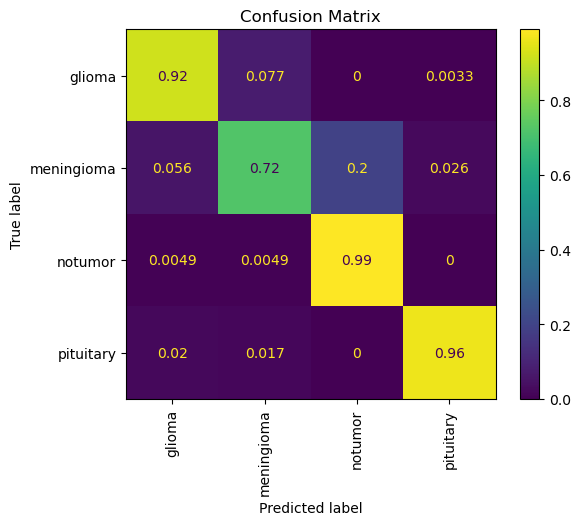

In [57]:
# Graficar la matriz de confusión
plot_confusion_matrix(true_labels, predicted_labels,class_names)
plt.show();

In [80]:
summary(best_model,(3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm2d: 1-1                       [-1, 3, 224, 224]         6
├─Conv2d: 1-2                            [-1, 16, 226, 226]        448
├─MaxPool2d: 1-3                         [-1, 16, 113, 113]        --
├─ReLU: 1-4                              [-1, 16, 113, 113]        --
├─Conv2d: 1-5                            [-1, 32, 115, 115]        4,640
├─MaxPool2d: 1-6                         [-1, 32, 57, 57]          --
├─ReLU: 1-7                              [-1, 32, 57, 57]          --
├─BatchNorm2d: 1-8                       [-1, 32, 57, 57]          64
├─Flatten: 1-9                           [-1, 103968]              --
├─Linear: 1-10                           [-1, 164]                 17,050,916
├─ReLU: 1-11                             [-1, 164]                 --
├─Dropout: 1-12                          [-1, 164]                 --
├─Linear: 1-13                           [-1, 4]                   660
Tot

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm2d: 1-1                       [-1, 3, 224, 224]         6
├─Conv2d: 1-2                            [-1, 16, 226, 226]        448
├─MaxPool2d: 1-3                         [-1, 16, 113, 113]        --
├─ReLU: 1-4                              [-1, 16, 113, 113]        --
├─Conv2d: 1-5                            [-1, 32, 115, 115]        4,640
├─MaxPool2d: 1-6                         [-1, 32, 57, 57]          --
├─ReLU: 1-7                              [-1, 32, 57, 57]          --
├─BatchNorm2d: 1-8                       [-1, 32, 57, 57]          64
├─Flatten: 1-9                           [-1, 103968]              --
├─Linear: 1-10                           [-1, 164]                 17,050,916
├─ReLU: 1-11                             [-1, 164]                 --
├─Dropout: 1-12                          [-1, 164]                 --
├─Linear: 1-13                           [-1, 4]                   660
Tot

In [61]:
best_models_index = [3,6,10,11,15]
train_accuracy = []
test_accuracy = []
models_names = []

In [62]:
for i in best_models_index:
    train_accuracy.append(evaluate_model(models_2[i],train_loader))
    test_accuracy.append(evaluate_model(models_2[i],test_loader))
    models_names.append('model {}'.format(i))

C:\Users\Academica\AppData\Local\Temp\ipykernel_15160\1764170150.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


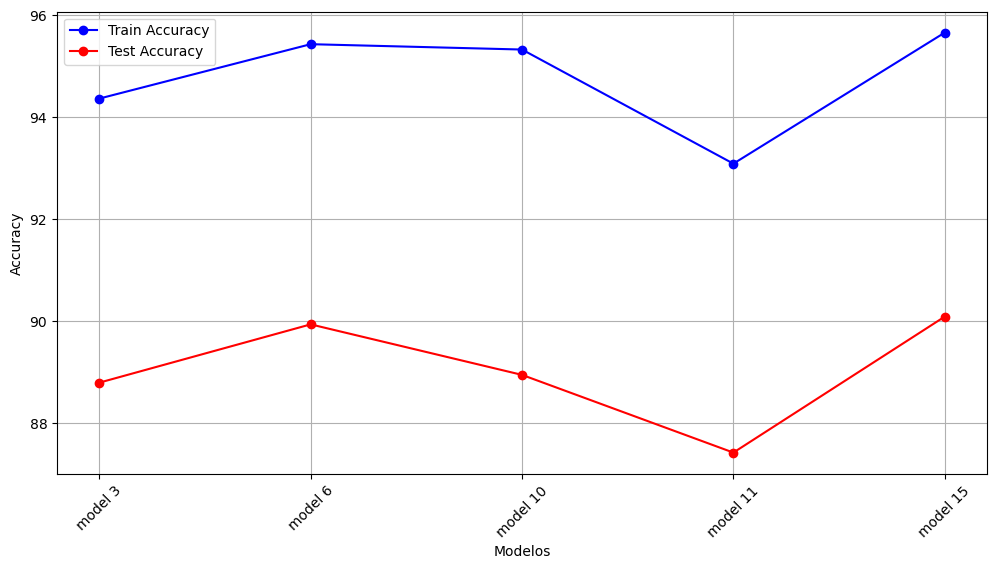

In [70]:
plt.figure(figsize=(12,6))
plt.plot(train_accuracy, color = 'blue', label='Train Accuracy',marker='o')
plt.plot(test_accuracy, color = 'red', label = 'Test Accuracy',marker='o')
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks([0,1,2,3,4],models_names,rotation=45)
plt.legend()
plt.show()